### Sentiment classification with Random Flips

In [ ]:
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
from util import load_directory_data,load_dataset,download_and_load_datasets,gpusession,random_flip_target
from cn_cls_class import cn_cls_class
from mlp_cls_class import mlp_cls_class
print ("Packages loaded.")

### Get feature

In [ ]:
dataset_name = 'movie_review'

In [ ]:
savename = 'data/' + dataset_name + '.npz'
FORCE_RELOAD = 0 
if os.path.isfile(savename) & (~FORCE_RELOAD): # load if the file exists,
    # Load 
    l = np.load(savename)    
    x_train = l['x_train']
    x_test = l['x_test']
    t_train = l['t_train']
    t_test = l['t_test']
    print ("[%s] Loaded. Size is [%.4f]MB" % (savename,os.path.getsize(savename)/1000./1000.))
else: # otherwise, make the data
    # Download dataset
    tf.logging.set_verbosity(tf.logging.ERROR) # Reduce logging output.
    train_df, test_df = download_and_load_datasets()
    # Check dataset
    for i in range(2):
        print (i,':',train_df['sentence'][i],'\n')
    for i in range(2):
        print (i,':',train_df['polarity'][i])
    embed_module = hub.Module("https://tfhub.dev/google/nnlm-en-dim128/1")
    embed_train = embed_module(tf.reshape(train_df["sentence"], shape=[-1]))
    embed_test = embed_module(tf.reshape(test_df["sentence"], shape=[-1]))
    with tf.train.MonitoredTrainingSession(is_chief=True) as sess:
        x_train = sess.run(embed_train)
        x_test = sess.run(embed_test)
    n_train,n_test = np.shape(x_train)[0],np.shape(x_test)[0]
    t_train,t_test = np.zeros((n_train,2)),np.zeros((n_test,2))
    for i in range(n_train):
        t_train[i,train_df['polarity'][i]] = 1
    for i in range(n_test):
        t_test[i,test_df['polarity'][i]] = 1    
    print("Shapes of 'x_train' and 'x_test' are %s and %s."%
          (x_train.shape,x_test.shape)) # (result: (1, 128))    
    print("Shapes of 't_train' and 't_test' are %s and %s."%
          (t_train.shape,t_test.shape)) # (result: (1, 128))    
    # Save 
    np.savez(savename,x_train=x_train,x_test=x_test,t_train=t_train,t_test=t_test)
    print ("[%s] Saved. Size is [%.4f]MB" % (savename,os.path.getsize(savename)/1000./1000.))

### Run

In [ ]:
VERBOSE = 0
r_seeds = [0,1,2,3,4]
rates = [0,0.1,0.2,0.3,0.4]
cn_train_accrs,cn_test_accrs = np.zeros((len(rates),len(r_seeds))),np.zeros((len(rates),len(r_seeds)))
mlp_train_accrs,mlp_test_accrs = np.zeros((len(rates),len(r_seeds))),np.zeros((len(rates),len(r_seeds)))
for s_idx,r_seed in enumerate(r_seeds):
    for r_idx,rate in enumerate(rates):
        # Add perturbation to t_label
        t_train_shuffle = random_flip_target(t_train,_rate=rate,_seed=r_seed)
        # Run ChoiceNet
        tf.reset_default_graph(); tf.set_random_seed(0)
        CN = cn_cls_class(_name='cn_cls_sentiment_%02derr_seed%d'%(rate*100,r_seed),_x_dim=128,_t_dim=2,_h_dims=[128,128],
                          _k_mix=5,_rho_ref_train=0.95,_tau_inv=1e-2,_pi1_bias=0.0,
                          _log_sigma_z_val=-2,_logsumexp_coef=0.1,_kl_reg_coef=0.1,
                          _actv=tf.nn.relu,_bn=slim.batch_norm,_l2_reg_coef=1e-6,_momentum=0.5,
                          _USE_SGD=False,_USE_MIXUP=False,_GPU_ID=0,_VERBOSE=VERBOSE)
        sess = gpusession();sess.run(tf.global_variables_initializer()) 
        CN.train(sess,_x_train=x_train,_t_train=t_train_shuffle,_x_test=x_test,_t_test=t_test,
                      _max_epoch=20,_batch_size=128,_lr=1e-4,_kp=0.95,
                      _LR_SCHEDULE=0,_PRINT_EVERY=10,_VERBOSE_TRAIN=True)
        # Run MLP
        tf.reset_default_graph(); tf.set_random_seed(0)
        MLP = mlp_cls_class(_name='mlp_cls_sentiment_%02derr_seed%d'%(rate*100,r_seed),_x_dim=128,_t_dim=2,_h_dims=[128,128],
                        _actv=tf.nn.relu,_bn=slim.batch_norm,_l2_reg_coef=1e-6,_momentum=0.5,
                        _USE_SGD=False,_USE_MIXUP=False,_GPU_ID=0,_VERBOSE=VERBOSE)
        sess = gpusession();sess.run(tf.global_variables_initializer()) 
        MLP.train(sess,_x_train=x_train,_t_train=t_train_shuffle,_x_test=x_test,_t_test=t_test,
                      _max_epoch=20,_batch_size=128,_lr=1e-4,_kp=0.95,
                      _LR_SCHEDULE=0,_PRINT_EVERY=10,_VERBOSE_TRAIN=True)
        # Append
        cn_train_accrs[r_idx,s_idx],cn_test_accrs[r_idx,s_idx] = CN.train_accr,CN.test_accr
        mlp_train_accrs[r_idx,s_idx],mlp_test_accrs[r_idx,s_idx] = MLP.train_accr,MLP.test_accr
        # Print
        print ("Seed:[%d] Err:[%d%%] ChoiceNet tr:%.2f te:%.2f MLP tr:%.2f te:%.2f"%
               (r_seed,rate*100,CN.train_accr,CN.test_accr,MLP.train_accr,MLP.test_accr))
    print ("Done.")
save_name = 'data/res_sentiment_flip.npz'
np.savez(save_name,cn_train_accrs=cn_train_accrs,cn_test_accrs=cn_test_accrs,
         mlp_train_accrs=mlp_train_accrs,mlp_test_accrs=mlp_test_accrs,
         rates=rates)
print ("[%s] Saved. Size is [%.4f]MB" % (save_name,os.path.getsize(save_name)/1000./1000.))

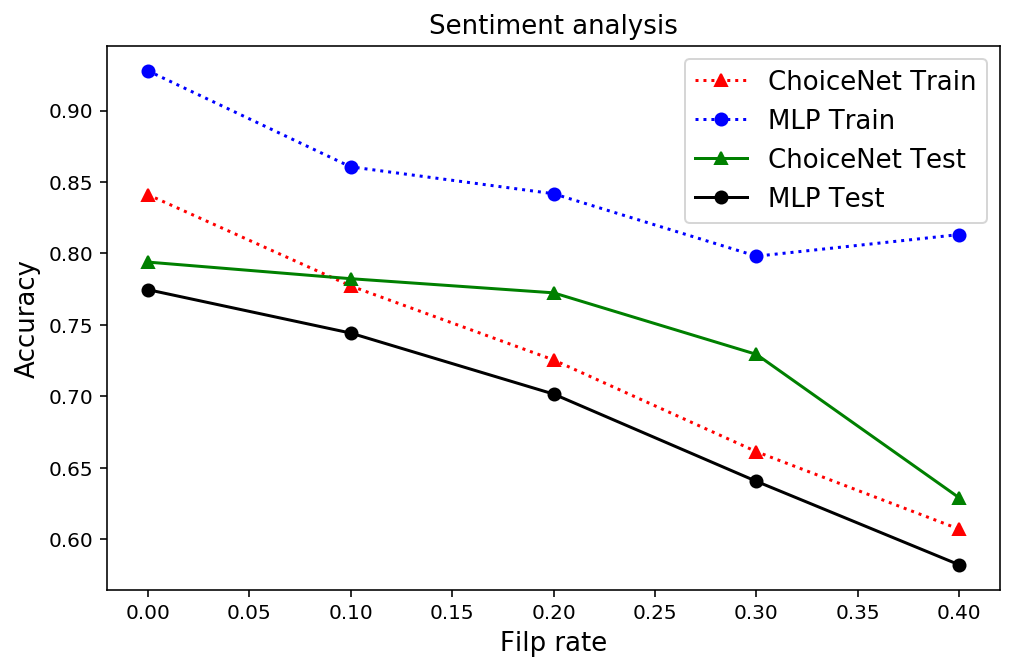

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

load_name = 'data/res_sentiment_flip.npz'
l = np.load(load_name)    
cn_train_accrs = l['cn_train_accrs']
cn_test_accrs = l['cn_test_accrs']
mlp_train_accrs = l['mlp_train_accrs']
mlp_test_accrs = l['mlp_test_accrs']
rates = l['rates']

plt.figure(figsize=(8,5))
h_cn_tr,=plt.plot(rates,cn_train_accrs.mean(axis=1),'r^:')
h_cn_te,=plt.plot(rates,cn_test_accrs.mean(axis=1),'g^-')
h_mlp_tr,=plt.plot(rates,mlp_train_accrs.mean(axis=1),'bo:')
h_mlp_te,=plt.plot(rates,mlp_test_accrs.mean(axis=1),'ko-')
plt.legend([h_cn_tr,h_mlp_tr,h_cn_te,h_mlp_te],
           ['ChoiceNet Train','MLP Train','ChoiceNet Test','MLP Test'],fontsize=13)
plt.xlabel('Filp rate',fontsize=13)
plt.ylabel('Accuracy',fontsize=13)
plt.title('Sentiment analysis',fontsize=13)
plt.show()